In [65]:
import os
import glob as blob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import glob
from pathlib import Path
from skimage import io

SEED = 42
np.random.seed(SEED)

In [58]:
root_dir = Path().cwd().parents[2]
data_dir = root_dir / "data"

print(root_dir)
print(data_dir)

/home/dkenez/Projects/PFAS---final-project
/home/dkenez/Projects/PFAS---final-project/data


The dataset structure:

```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

In [33]:
TRAIN = True #Set to FALSE to run end to end without traning
# Number of epochs to train for.
EPOCHS = 25

### Visualize a Few Ground Truth Images

In [68]:
class_names = ["Car", "Pedestrian", "Cyclist"]
colors = np.random.uniform(0, 255, size=(len(class_names), 3))


In [35]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [36]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [66]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = list(image_paths.glob("*.jpeg"))
    all_training_labels = list(label_paths.glob("*.txt"))
    print(image_paths)
    print(len(all_training_images), len(all_training_labels))
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = io.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

/home/dkenez/Projects/PFAS---final-project/data/processed/KITTI/images
978 978


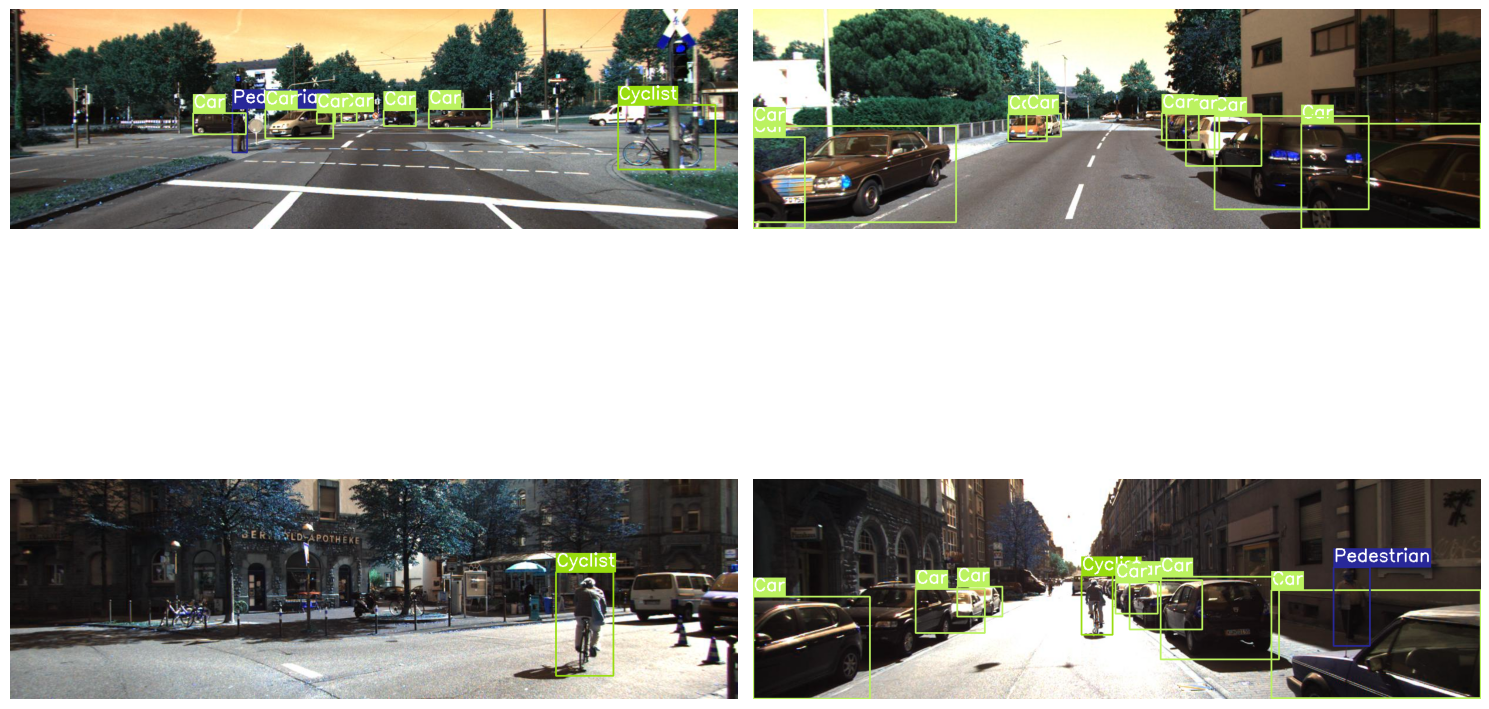

In [69]:
# Visualize a few training images.
plot(
    image_paths=data_dir / "processed/KITTI/images/",
    label_paths=data_dir / "processed/KITTI/labels/",
    num_samples=4,
)


## Helper Functions for Logging

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository

In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [ ]:
%cd yolov5/
!pwd

/home/dkenez/Projects/PFAS---final-project/src/models/yolov5
/home/dkenez/Projects/PFAS---final-project/src/models/yolov5


In [ ]:
!pip install -r requirements.txt

## Training using YOLOV5

In [21]:
monitor_tensorboard()

ModuleNotFoundError: No module named 'tensorboard'

In [72]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 2
results_3
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /home/dkenez/Projects/PFAS---final-project/src/models/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.11.2 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0

### Visualization and Inference Utilities

In [24]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [25]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [26]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

In [27]:
show_valid_results(RES_DIR)

NameError: name 'RES_DIR' is not defined

### Inference on Images

In [28]:
#To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.

# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

NameError: name 'RES_DIR' is not defined

In [29]:
visualize(IMAGE_INFER_DIR)

NameError: name 'IMAGE_INFER_DIR' is not defined